In [1]:
#importing all the various libraries

from glob import glob
import itertools
import os.path
import re
import tarfile
import time
import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

from html.parser import HTMLParser
from urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Like the saying goes: good developers copy code, great developers paste; we are not going to be writing all codes from the ground up. My approach here is to refactor code and give credit where due to fasten development.

First is HTML parsing code by Eustache Diemert. The code was very well layed out and efficient compared with all other code snippet i found online. Scikit-learn gave his contribution a thumbs up, so i figured i settle. This code basically downloads the files from the URL, unzips it and rebuilds the SGML files into a one file. One can also download the zip file and do the same.

In [2]:
# Credit goes to Eustache Diemert <eustache@diemert.fr>
# @FedericoV <https://github.com/FedericoV/>
# @https://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html
# License: BSD 3 clause
# 

class ReutersParser(HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        self.attributes = dict(attributes) # Attributes is a list of pairs
        #pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics,
                         'new_id': self.attributes["newid"],})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('https://drive.google.com/drive/folders/1k7MNpw_huZTL9opXU9e7u6M8phupPih7')
    ARCHIVE_FILENAME = 'reuters21578-20211018T220355Z-001.zip'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        os.mkdir(data_path)
        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path, reporthook=progress)
        
        tarfile.open(archive_path, 'r:gz').extractall(data_path)

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc           

**GLIMPSE INTO THE DATASET**

In [3]:
#printing the first 5 documents

full_list = list(stream_reuters_documents())
full_list[:3]

[{'title': 'BAHIA COCOA REVIEW',
  'body': 'Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this co

In [4]:
#total number of documents in all files
len(full_list)

21578

In [5]:
#merging the body and topics elements in the documents
data_labels = [(x['body'], x['topics']) for x in list(stream_reuters_documents())]

In [6]:
#checking for empty topic lists
[w for w in data_labels if w[1] == []][:7]

[('', []),
 ('', []),
 ('', []),
 ('', []),
 ('', []),
 ('<Pacific Western Airlines Corp> said it integrated the senior management of Pacific Western and recently acquired Canadian Pacific Air Lines Ltd in preparation for the companies\' merger this summer. Pacific Western said it appointed president and chief executive Rhys Eaton as chairman and chief executive in the new management structure, and Murray Sigler as president. Sigler was previously president of Pacific Western\'s airline unit, Pacific Western Airlines Ltd. Pacific Western acquired Canadian Pacific Air Lines for 300 mln dlrs last December from Canadian Pacific Ltd <CP>. Canadian Pacific Air Lines said president and chief executive Donald Carty and four senior vice-presidents resigned last week. Carty said in a company memorandum that he accepted another senior post in commercial aviation and that some of the vice-presidents were taking early retirment and others were resigning for personal reasons. Pacific Western said t

In [7]:
#quick statistics of number of documents 
new_full_list = [b for b in full_list if not b['body'] == '' and not b['topics'] == []]
unseen_list = [b for b in full_list if not b['body'] == '' and b['topics'] == []]
empty_body_topic = [x for x in full_list if x['body'] == '' and x['topics'] == []]

print('total # of documents in the 20 sgml files:', len(full_list),)
print('# of documents with no missing body & topic values:', len(new_full_list),)
print('# of documents with missing topic values:', len(unseen_list),)
print('# of documents with both body & topics values missing:', len(empty_body_topic),)
print('# of documents that are all null:', len(full_list) - (len(new_full_list) + len(unseen_list) + len(empty_body_topic)))

total # of documents in the 20 sgml files: 21578
# of documents with no missing body & topic values: 18457
# of documents with missing topic values: 586
# of documents with both body & topics values missing: 1276
# of documents that are all null: 1259


Since this a supervised learning model, we are going to be doing the following: 
- We are going to be getting the train and test sets from the documents with no missing body & topic values above
- Deleting the documents that are all null (i.e., has nothing in the documents)
- Deleting the documents that have items in them, but missing the body and topics values. In a way this is questionable, and should be revisted if the overall performance of the model is subpar. It will be interesting to see the effect of filling the data & topics with nulls or some arbitrary string values would have on the overasll model performance
- Last, we use the documents with the missing topics to do final prediction after the analysis. We can also add the examples back into the training set after prediction and then run another training on the concatenated training set much like semi-supervised learning to see if this improves the model.

In [8]:
#split the body and topics into features and labels respectively
labels = [x['topics'] for x in new_full_list]
data = [x['body'] for x in new_full_list]

In [9]:
#what the data in a document looks like
data[0]

'Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this cocoa would be fit for export as shippers are

In [10]:
#what the lablels for first document looks like
labels[0]

['cocoa', 'el-salvador', 'usa', 'uruguay']

**SPLITTING THE DATASET INTO TRAIN & TEST SETS**

Now is the time to split the data into train and test sets to prevent data leakage and snopping. I am using an arbitrary split of 80/20, i.e., 80% of the dataset will be in the training set and 20% of the data will be in the test set. This split can actually be a custom hyperparamter one can tune on the dataset to know what proportion of split gets the max performance on the model. However, leaving this as arbitrary for now. 

In [11]:
#splitting the data into the training and the test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

NOTE: I would have loved to use the stratified split on this analysis, but for reasons I will mention later. 

In [12]:
len(X_train), len(y_train)

(14765, 14765)

In [13]:
X_train[0]

'First Southern Federal Savings and Loan Association said it has agreed in principle to acquire Horizon Financial Corp and Horizon Funding corp from <Victor Federal Savings and Loan Association> of Muskogee, Okla., for undisclosed terms. The company said the purchase is subject to approval of the boards of First Southern and Victor and regulatory agencies. Horizon Financial services mortgage loans and Horizon Funding is a wholesale loan purchasing operation. Horizon services 3.2 billion dlrs in mortgage loans. Reuter '

**CLEANING OF THE BODY OF THE DOCUMENTS**

For cleaning of the data, we are using snippet from Irfan Alghani Khalid as is with a little refactoring 

In [14]:
import nltk
import string
from nltk.corpus import stopwords

stop_words = stopwords.words("english")


def text_preproc(x):
    """
    credit goes to Irfan Alghani Khalid 
    @https://towardsdatascience.com/cleaning-text-data-with-python-b69b47b97b76
    """
   
    x = x.lower()
    x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    x = x.encode('ascii', 'ignore').decode()
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'@\S+', ' ', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    return x

In [15]:
X_train = [text_preproc(x) for x in X_train]
X_test = [text_preproc(x) for x in X_test]

In [16]:
X_train[0]

'first southern federal savings loan association said agreed principle acquire horizon financial corp horizon funding corp victor federal savings loan association muskogee okla undisclosed terms company said purchase subject approval boards first southern victor regulatory agencies horizon financial services mortgage loans horizon funding wholesale loan purchasing operation horizon services billion dlrs mortgage loans reuter '

In [17]:
y_train[:7]

[['acq', 'usa'],
 ['sugar', 'mauritius', 'uk'],
 ['acq', 'usa'],
 ['usa'],
 ['usa'],
 ['usa'],
 ['grain', 'orange', 'sugar', 'china']]

In [18]:
len(y_train)

14765

**PREPROCESSING OF THE FEATURES AND MULTILABELS**

In [19]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
stop_words = stopwords.words("english")

#tokenization
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18, alternate_sign=False)
#vectorizer = TfidfVectorizer(stop_words=stop_words,)

#learn & transform
vectorized_train_docu = vectorizer.fit_transform(X_train)
vectorized_test_docu = vectorizer.transform(X_test)

#transform multilabel labels
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(y_train) 
test_labels = mlb.transform(y_test)

**PREDICTION AND EVALUATION**

In [20]:
#initialize classifer
classifier=OneVsRestClassifier(LinearSVC(random_state=42, class_weight='balanced'))

Balancing the class weight here helps to increase emphasis on the labels with lower occurrences and vice versa for ones with higher ones. 

In [21]:
#fitting the classier to the data
classifier = classifier.fit(vectorized_train_docu, train_labels)

#prediction
predictions = classifier.predict(vectorized_test_docu)

#converting predictions back to actual labels
all_labels = mlb.inverse_transform(predictions)

In [22]:
def pred_eval(classifier, train_data, training_label, test_data, test_labels):
    from sklearn.model_selection import KFold, cross_val_score
    
    kf = KFold(n_splits=5, random_state = 42, shuffle = True)
    scores = cross_val_score(classifier, train_data, training_label, cv = kf)
    
    predictions = classifier.predict(test_data)

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
 
    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    return scores.mean(),  micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, macro_f1

In [23]:
accuracy, micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, macro_f1 = pred_eval(classifier, 
                                                    vectorized_train_docu, train_labels, vectorized_test_docu, test_labels)

In [24]:
compare_df = pd.DataFrame({'benchmark': [accuracy, micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, 
                                         macro_f1],},
                            index = ['Accuracy', 'Micro_precision', 'Micro_recall', 'Micro_f1', 'Macro_precision', 
                                    'Macro_recall', 'Macro_f1'])

In [25]:
compare_df

,benchmark
Accuracy,0.587674
Micro_precision,0.842428
Micro_recall,0.846628
Micro_f1,0.844523
Macro_precision,0.432634
Macro_recall,0.369155
Macro_f1,0.385330


This is a benchmark we will be working with. Few questions we need to address are:
 - Can we do better than these benchmarks?
 - Why did this model underperform?
 - How can we improve this?

**Can we do better than these benchmarks?**

Of course yes! The accuracy is barely close to a coin toss, which is somewhat evidenced by averaging the F1-score of both the Micro and Macro average statistics

The accuracy score metric is not a good indicator in this analysis because the labels are greatly imbalanced. The model in some way will be biased toward the majority labels and classes. This can be evidenced from the statistics from the Micro-average quality numbers and the Macro-average quality numbers of the precision, recall and F1-scores. Those interested can read more about those statistics @: 
- https://stats.stackexchange.com/questions/156923/should-i-make-decisions-based-on-micro-averaged-or-macro-averaged-evaluation-mea and 
- https://stats.stackexchange.com/questions/156923/should-i-make-decisions-based-on-micro-averaged-or-macro-averaged-evaluation-mea

General consensus is that for multiclass classification, the Micro-average quality numbers is preferable. However, for a multilabel classification, which is what we are implementing in this analysis, both of the metrics should be about same or comparable to achieve good predictive analysis


**Why did this model underperform?**

Let us run a few exploratory data analysis on the data to see the patterns

In [26]:
import itertools
merged_labels = list(itertools.chain(*labels)) #flattening list of list

In [27]:
#creating a dataframe sorted by the number of counts of each labels in the documents and printing top 15 examples
import collections
counter=collections.Counter(merged_labels)
df = pd.DataFrame(zip(counter.keys(), counter.values()), columns = ['labels', 'counts'])
df2 = df2 = df.sort_values(by='counts', ascending=False)
df2.head(15)

,labels,counts
2,usa,12322
20,earn,3776
21,acq,2210
29,uk,1451
64,japan,1104
27,canada,1063
69,money-fx,684
5,grain,574
52,crude,566
113,west-germany,558


In [28]:
#printing the bottom three examples
df2.tail(15)

,labels,counts
398,steeg,1
397,lin-meal,1
395,dkr,1
393,skr,1
392,vanuatu,1
391,mauritania,1
390,young,1
268,imco,1
386,set,1
383,ryzhkov,1


NOTE: The DataFrame above shows why a stratified split would not work as mentioned earlier. This is because the least populated class in labels has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [29]:
#total number of unique labels in the training set 
len(df2)

444

In [30]:
# all unique labels in the train set
counter.keys()

dict_keys(['cocoa', 'el-salvador', 'usa', 'uruguay', 'brazil', 'grain', 'wheat', 'corn', 'barley', 'oat', 'sorghum', 'veg-oil', 'linseed', 'lin-oil', 'soy-oil', 'sun-oil', 'soybean', 'oilseed', 'sunseed', 'argentina', 'earn', 'acq', 'yemen-arab-republic', 'copper', 'venezuela', 'reagan', 'housing', 'canada', 'coffee', 'uk', 'ico-coffee', 'iran', 'ship', 'sugar', 'trade', 'reserves', 'new-zealand', 'panama', 'honduras', 'money-supply', 'wilson', 'meal-feed', 'soy-meal', 'maxwell', 'philippines', 'rye', 'cotton', 'iraq', 'carcass', 'livestock', 'china', 'nyse', 'crude', 'opec', 'nat-gas', 'algeria', 'cpi', 'gnp', 'switzerland', 'oecd', 'ussr', 'lyng', 'volcker', 'south-korea', 'japan', 'france', 'chirac', 'italy', 'russell', 'money-fx', 'interest', 'hong-kong', 'taiwan', 'bop', 'australia', 'keating', 'rice', 'thailand', 'red-bean', 'ongpin', 'colombia', 'rubber', 'copra-cake', 'palm-oil', 'palmkernel', 'tea', 'plywood', 'indonesia', 'kuwait', 'ecuador', 'worldbank', 'india', 'gandhi', '

**SOME EXPLORATORY DATA ANALYSIS**

In [31]:
#function to plot the counts of the occurrences of the labels
def df_occr(dataframe, limit=None):
    df = dataframe.head(limit)
    df.plot(x='labels', y='counts', kind='bar', legend=False, grid=True, figsize=(15, 10))
    plt.title("Counts of each labels across all documents")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('category', fontsize=12)

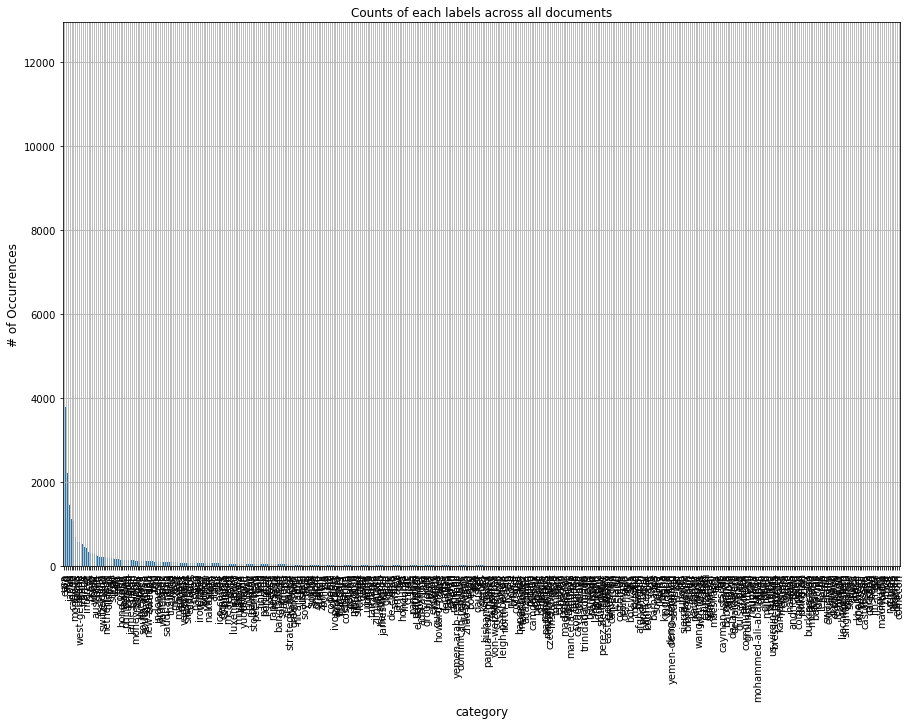

In [32]:
df_occr(df2)

Since a label cannot appear more than once for a document; the plot above shows the labels aren't evenly distributed across all documents. This means some labels are sparser than others, which will cause a bias towards the dominant labels.

Zooming into the plot ...

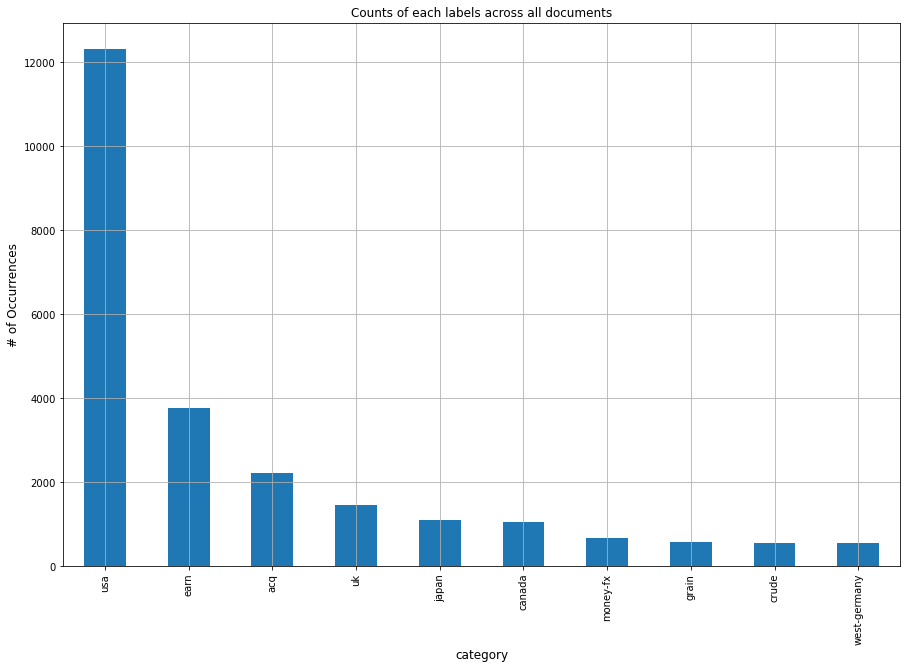

In [33]:
df_occr(df2, 10)

Zooming out ...

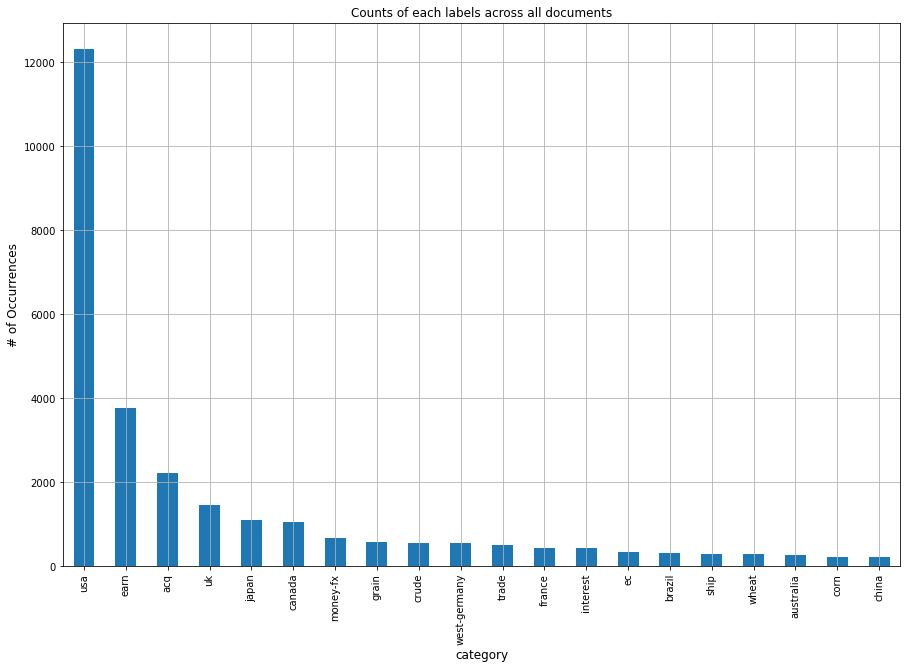

In [34]:
df_occr(df2, 20)

Zooming out even more .....

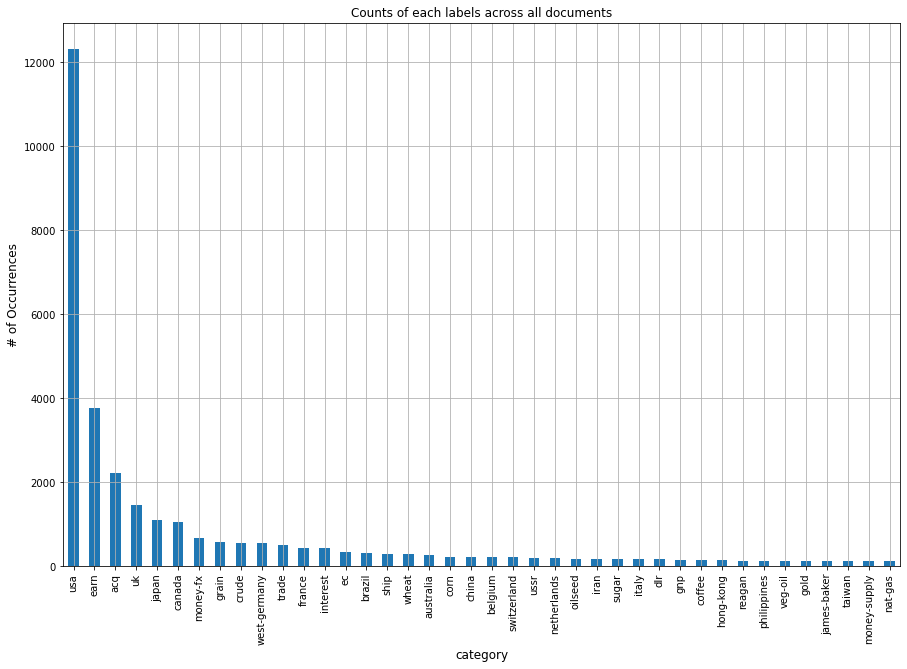

In [35]:
df_occr(df2, 40)

So we get the point. 

We see that beyond money-fx and grain, the count of the labels are about the same. Occurrences of labels before that basically dominates.

A way to solve this is making the classes somewhat evenly distributed by combining classes. This is an art, not a science and will depend on objectives and how effective one needs the predicitive abilities from the data. Combining labels maybe also require some domain knowledge to achieve a grouping that makes sense. For the purpose of this work, we will just exemplify this approach to see it's effectiveness.  

I will hypothetically use the first three dominant labels, i.e.; usa, earn and acq, as the positive classes and everything else the negative classes. So, when we binarize the labels, we get a 1, where we see usa, earn and acq respectively and zero otherwise. Which is a total of 4 labels.

Let's give it a shot!


**SOME PREPROCESSING OF THE DATASET**

In [36]:
# Created a function that will do this merge or groupings
# number of labels ranges from 0 to 90
# label type is either y_train or y_test

def label_merge(label_type, number_of_label=1, ):
    """
     This function allows one merge or group labels

     number_of_positive_labels: where positve label is 1 and all other\
     labels are merged/grouped into the negative label 0. original number\
     of labels ranging from 0 to 90.
     
     label_type: this either the y_test (labels of the test set) or \
     y_train (labels of the train set)
     
     """
    
    new_labels = df2.head(number_of_label).labels.values.tolist()
    for ele in (label_type):
        for i, x in enumerate (ele):
            if x in new_labels:
                continue
            else: 
                ele[i] = 'merged'

In [37]:
#applying the merge function to the train and test labels
label_merge(y_train, 3)
y_train[:5]

[['acq', 'usa'],
 ['merged', 'merged', 'merged'],
 ['acq', 'usa'],
 ['usa'],
 ['usa']]

In [38]:
y_train[:11]

[['acq', 'usa'],
 ['merged', 'merged', 'merged'],
 ['acq', 'usa'],
 ['usa'],
 ['usa'],
 ['usa'],
 ['merged', 'merged', 'merged', 'merged'],
 ['acq', 'usa'],
 ['usa'],
 ['merged', 'merged', 'merged', 'merged'],
 ['earn', 'usa']]

In [39]:
import itertools
import collections

def df_occr2(labels):
    
    merged_labels = list(itertools.chain(*labels)) #flattening list of list
    
    #creating a dataframe sorted by the number of counts of each labels in the documents
    counter=collections.Counter(merged_labels)
        
    df = pd.DataFrame(zip(counter.keys(), counter.values()), columns = ['labels', 'counts'])
    df2 = df.sort_values(by='counts', ascending=False)
    
    #df3= df2.head(limit)
    df2.plot(x='labels', y='counts', kind='bar', legend=False, grid=True, figsize=(15, 10))
    plt.title("Counts of each labels across all documents")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('category', fontsize=12)

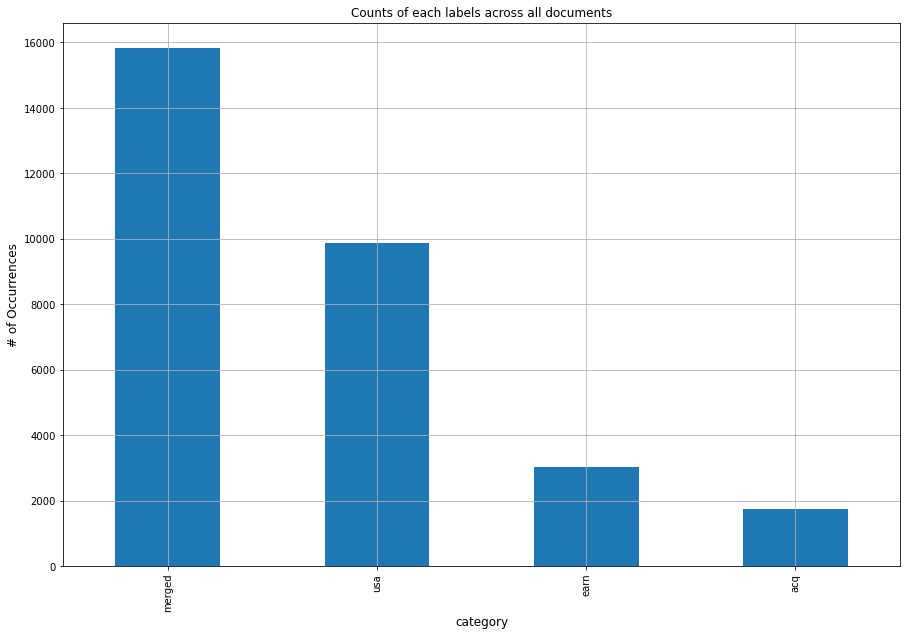

In [40]:
#calling the function for the plot
df_occr2(y_train)

The plot above after merging the labels is much better and has less bias in the training set. The distribution looks much better across all documents, but then it's not the best. The labels in the merged group still trumps all the other labels.

In [41]:
#running the same merge fucntion on the test set
label_merge(y_test, 3)

In [42]:
#transform multilabel labels
train_labels = mlb.fit_transform(y_train) 
test_labels = mlb.transform(y_test)

In [43]:
#fit the model on the new merged labels
classifier = classifier.fit(vectorized_train_docu, train_labels)

#prediction and evaluation on the new merged labels
accuracy, micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, macro_f1 = pred_eval(classifier, 
                                                    vectorized_train_docu, train_labels, vectorized_test_docu, test_labels)

In [44]:
#comparing the improved model and the benchmark
compare_df['3_+ve_class'] =  [accuracy, micro_precision, micro_recall, micro_f1, macro_precision, 
                                             macro_recall, macro_f1]                            

In [45]:
compare_df

,benchmark,3_+ve_class
Accuracy,0.587674,0.823163
Micro_precision,0.842428,0.933212
Micro_recall,0.846628,0.927306
Micro_f1,0.844523,0.930249
Macro_precision,0.432634,0.905656
Macro_recall,0.369155,0.921369
Macro_f1,0.385330,0.912667


In [46]:
def plots(item, title=None):

    '''
     This function allows one quickly plot bar charts of \
     different subset variants of the performance metrics dataframe \

     item: either a list of DataFrame names i.e., ['a', 'b', ..] or \
     or just a single name i.e., 'a.'
     title: title of the plot. should be string data type

     return value is the reuired plots

     '''

    compare_df[item].plot(kind="bar")
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12, 8)
    
    plt.title(title)
    plt.xlabel("metrics")
    plt.ylabel("quantity")
    plt.xticks(rotation=360) # Rotate x-labels
    plt.legend(loc="lower right")
    plt.show()
    return plt.show()


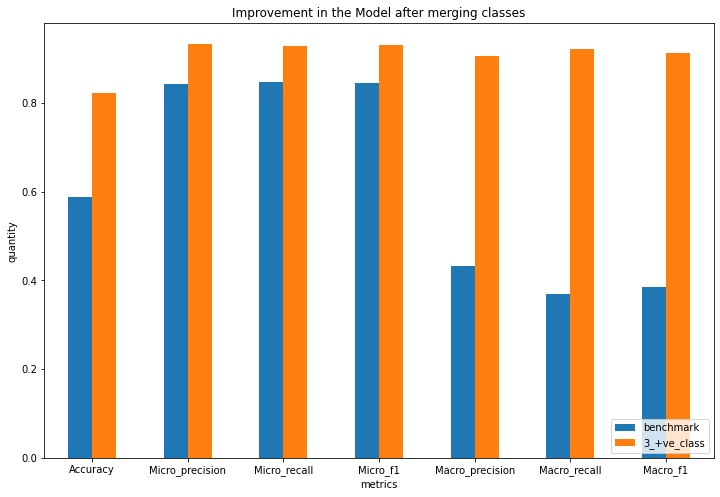

In [47]:
#plotting improvement in the RF model after hyperparameter tuning
plots(['benchmark', '3_+ve_class'], 'Improvement in the Model after merging classes')


The above shows the improvement in the distribution of the labels across the documents by merging the labels greatly improved the macro-average statistics, which was what we were trying to achieve.

However, what we just did here may not make business or domain sense. One can't combine labels just to achieve a good predictive ability without taking cognizant of business objectives. There are better ways to combine labels in the preprocessing steps. One is using much better groupings that aligns with the domain or process at hand. This can't be carried out here because some grouping labels like the country label groupings will dominate, creating bias towards those labels. 

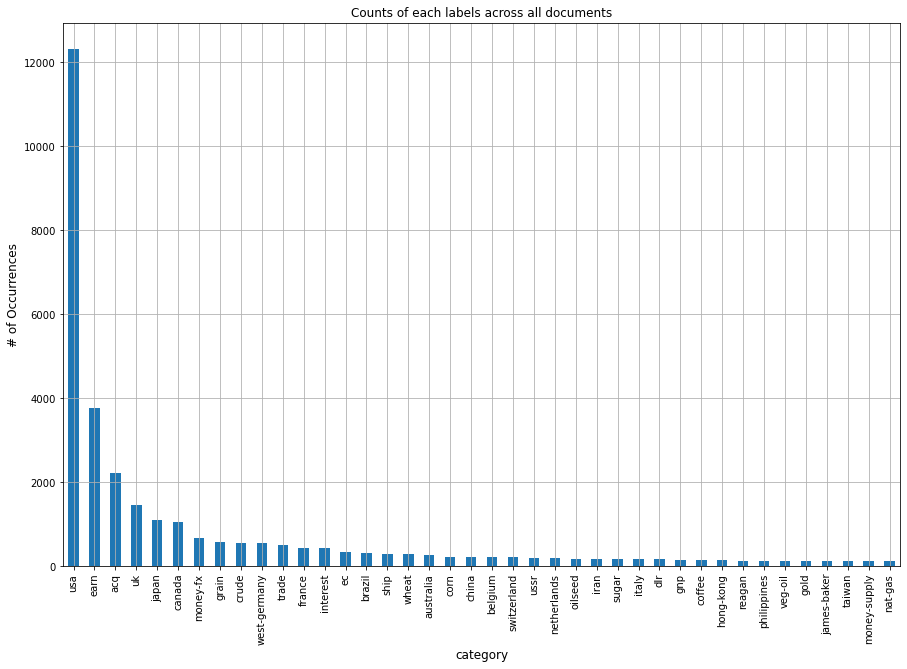

In [48]:
df_occr(df2, 40)

We see that the usa, uk, japan and canada labels make up more than 80% of all labels in the document.

A much better groupings of the labels that makes sense, and still achieves good predictive ability can be "top three label" vs "not a top three label." From the below plot as seen earlier ....

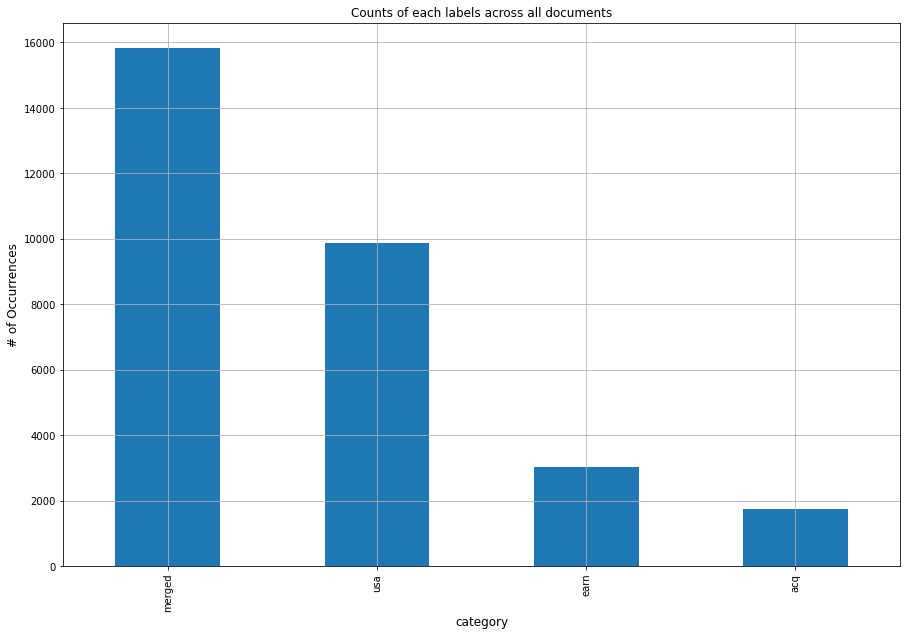

In [49]:
#calling the function for the plot
df_occr2(y_train)

From the above, we see that when we stack the usa, earn and acq labels, the occurrences and distribution of the merged output positive label evens out with the negative one. Let's try that. 

In [50]:
def label_merge_top(label_type,):
    """
     This function is a variant of the label_merge function with\
     the top three labels: ['usa', 'earn', 'acq'] hardcoded, and \
     merged into one label. 
     
     """
    
    new_labels = df2.head(3).labels.values.tolist()
    for ele in (label_type):
        for i, x in enumerate (ele):
            if x in new_labels:
                ele[i] = 'top_three_label'
                #continue
            else: 
                ele[i] = 'not_a_top_three_label'

In [51]:
label_merge_top(y_train)
label_merge_top(y_test)

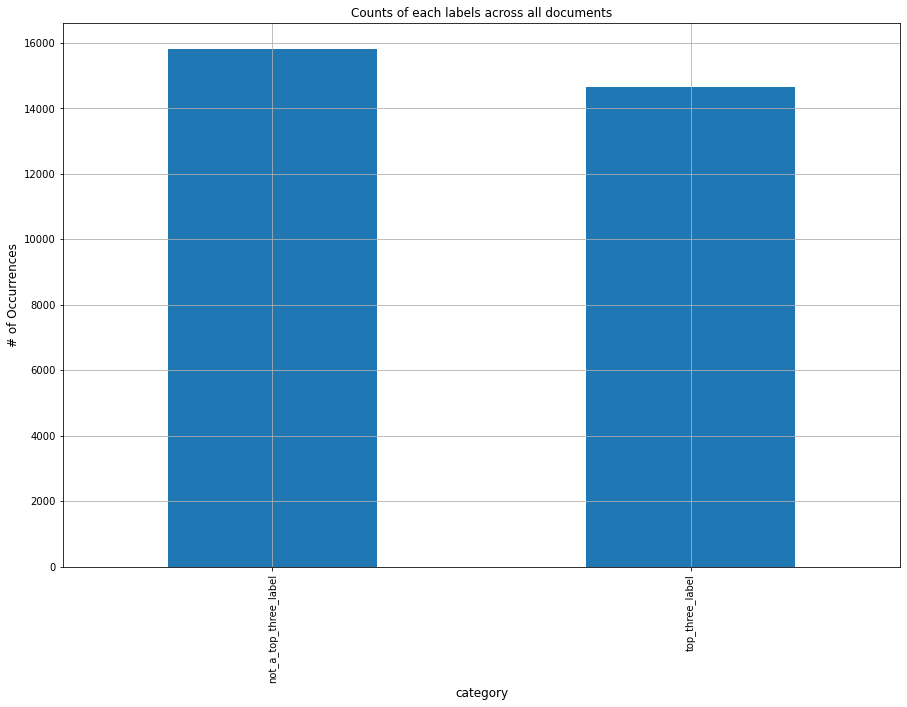

In [52]:
df_occr2(y_train)

There we go! This further reduces the bias towards a label groupings in the dataset

Let us check the predictive ability ...

In [53]:
#transform multilabel labels
train_labels = mlb.fit_transform(y_train) 
test_labels = mlb.transform(y_test)

#fit the model on the new merged labels
classifier = classifier.fit(vectorized_train_docu, train_labels)

#prediction and evaluation on the new merged labels
accuracy, micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, macro_f1 = pred_eval(classifier, 
                                                    vectorized_train_docu, train_labels, vectorized_test_docu, test_labels)

#comparing the binary model with ;ast two models
compare_df['binary_model'] =  [accuracy, micro_precision, micro_recall, micro_f1, macro_precision, 
                                             macro_recall, macro_f1]                            

In [54]:
compare_df

,benchmark,3_+ve_class,binary_model
Accuracy,0.587674,0.823163,0.870843
Micro_precision,0.842428,0.933212,0.958829
Micro_recall,0.846628,0.927306,0.926614
Micro_f1,0.844523,0.930249,0.942446
Macro_precision,0.432634,0.905656,0.957391
Macro_recall,0.369155,0.921369,0.923959
Macro_f1,0.385330,0.912667,0.940361


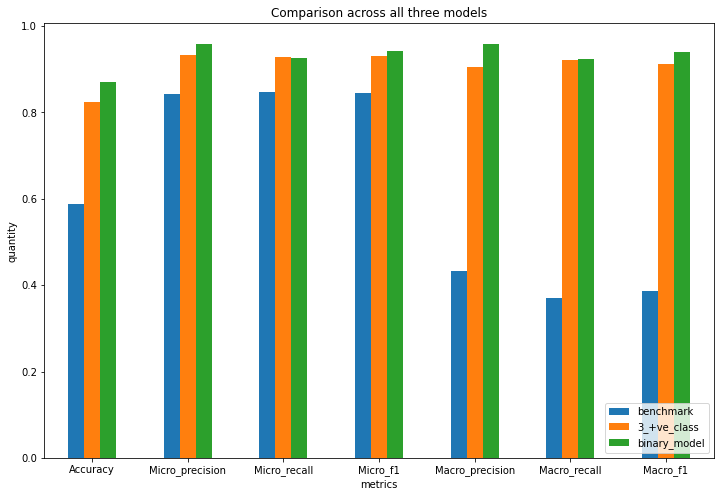

In [55]:
#plotting improvement in the model across all models
plots(['benchmark', '3_+ve_class', 'binary_model'], 'Comparison across all three models')


The above shows the binary model performs better than the previous two models. We could have just used a Logistic Regression model for the binary model scenario, but didn't try it in this instance.

Usually an approach like this works for cases where there is an uneven distribution in observations across all classes. One sure will achieve a much better solution. 

According to Google machine learning best practices, it is better to start simple like this, and then scale out. Also, breaking tasks down, then modeling each task and combining overall effect may improve performance of the model. That is much like a cascaded modeling approach where output of one model acts as input of another. That is, after using a binary model of say "top three label" vs "not a top three label," one will now drill down with another model to predict actual label in the grouping. Which is a model of a models, where one is a function of the other. Much like gradient boosting.

I'd probably try that if i have time.

**BIAS & VARIANCE CHECKS**

Would additional "good examples" improve the model? Let us see ....

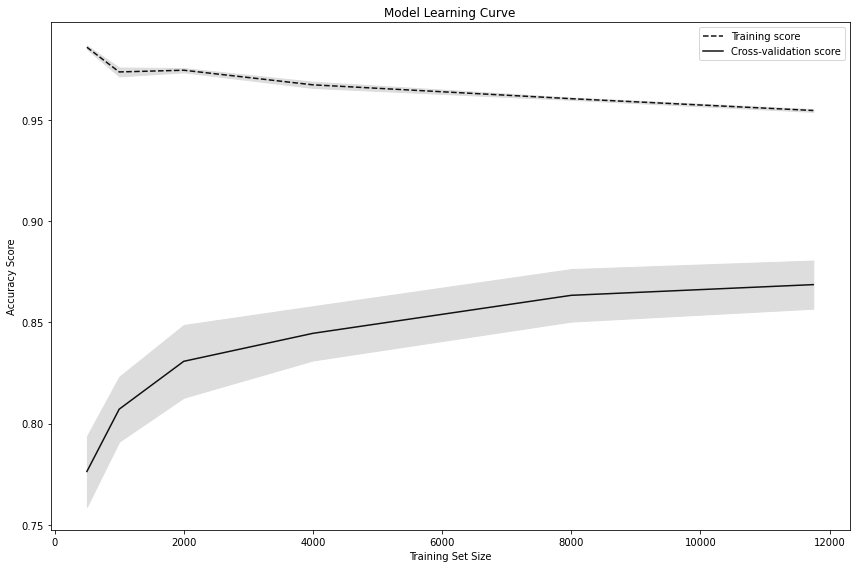

In [56]:
# plot credit goes to Chris Albon
# @https://chrisalbon.com/code/machine_learning/model_evaluation/plot_the_learning_curve/

from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(classifier, vectorized_train_docu, train_labels, cv=20, 
                                                                     scoring='accuracy', n_jobs=-1,
                                                                     train_sizes=[500, 1000, 2000, 4000, 8000, 11747])

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
plt.plot(train_sizes, valid_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color="#DDDDDD")

# Create plot
plt.title("Model Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

The learning curve above shows how much improvement a model makes with an increase in the training set size. We need to see in the plot that the cross-validated solid line gets close to the training score dashed line as much as possible.

The training dataset we have here is shy of about 12000 examples, after train-test split and treatment of null documents, which is small in this case. So, care was taken not to unnecessarily drop data points without thoroughly understanding and investigating its effects.

The learning curve above shows our model performs better with increasingly additional examples. So, another way one can reduce bias, and increase model performance and accuracy is getting more quality data in this case.

**Is the model underfitting, overfitting or just right?**

That was probably already obvious from the initial cross-validation metrics, but one may still need some confirmation.
To do that, we compare some hyperparameter values for both the training set and the cross-validated set. Overfitting the training set means the hyperparameter value score is very different for both. That means the hyperparameter score for the training set is high and one for the cross-validation score low. If the scores are about the same and low, then that indicates underfitting. In both cases, the model will not generalize well to out of sample dataset.

Let us print out the hyperparameters for our base algorithm - LinearSVC

In [57]:
classifier.get_params().keys()

dict_keys(['estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__loss', 'estimator__max_iter', 'estimator__multi_class', 'estimator__penalty', 'estimator__random_state', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs'])

To investigate this, we can use one or two hyperparameters. 

Let us try the 'estimator__C.' That is the regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.The default for that hyperparameter is 1. But we will try values between 0 and 10

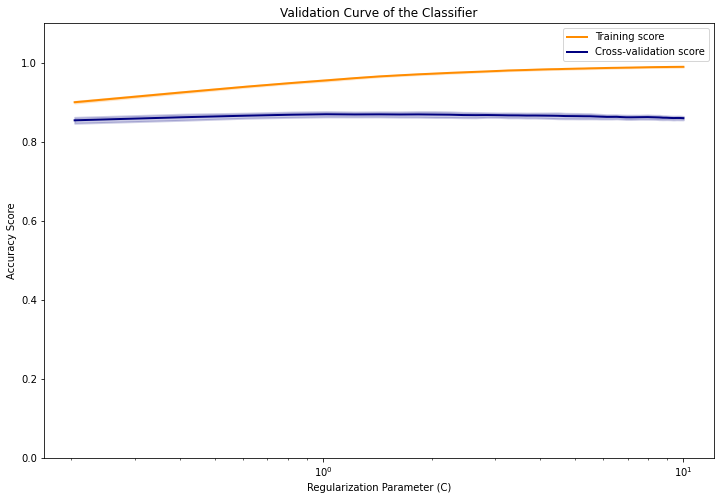

In [58]:
#@ credit goes to https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html\
#sklearn.model_selection.validation_curve


from sklearn.model_selection import validation_curve
np.random.seed(0)

X, y = vectorized_train_docu, train_labels
param_range = np.linspace(0, 10, num=50)
train_scores, valid_scores = validation_curve(classifier, X, y, param_name='estimator__C', param_range=param_range, cv=5,
                                              scoring="accuracy", n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)

plt.title("Validation Curve of the Classifier")
plt.xlabel(r"Regularization Parameter (C)")
plt.ylabel("Accuracy Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
 color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
 train_scores_mean + train_scores_std, alpha=0.2,
 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
 color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
 valid_scores_mean + valid_scores_std, alpha=0.2,
 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

We see that the hyperparameter value is very close for both the training and validation set from the above. Both curves are just starting to diverge. If we instead see the orange line going up and the blue line score retreating or declining, that should be a sign of overfitting. It is also not underfitting since we don't see both the curves either falling or with a
low score.

We see from the above that the variance of the model increases as C does, and the sweet spot is closer to 0 than the default we used. Meaning a value of C right around 0.2 should be ideal. The more the variance, the more the model overfits. However, the model is not overly overfitting so leaving it as is. One can set the value of C to 0.2 when retraining the model though.

Always good to check another hyperparameter to confirm we are not overfitting. Let us also try the 'estimator__max_iter' hyperparameters, which is maximum number of interations run across all classes. We could have written the previous plot code as a function and just pass the hyperparemeter as an argument. But i'd just copy and paste code below because i am lazy...

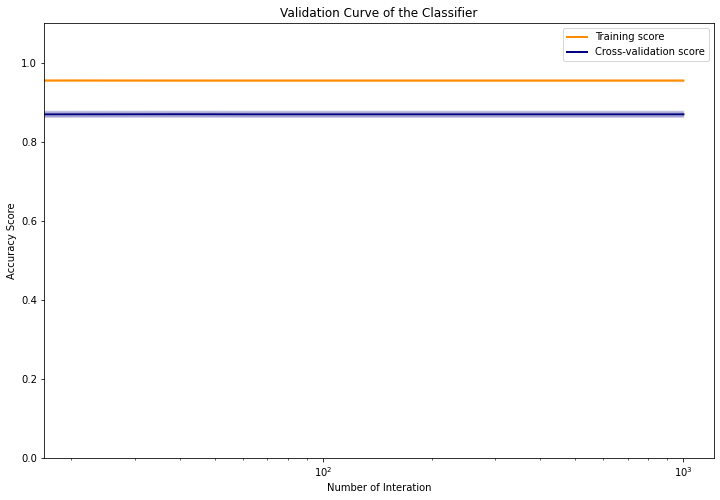

In [59]:
# credit goes to https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html\
#sklearn.model_selection.validation_curve


from sklearn.model_selection import validation_curve
np.random.seed(0)

X, y = vectorized_train_docu, train_labels
param_range = np.linspace(0, 1000, num=50)
train_scores, valid_scores = validation_curve(classifier, X, y, param_name='estimator__max_iter', param_range=param_range, cv=5,
                                              scoring="accuracy", n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)

plt.title("Validation Curve of the Classifier")
plt.xlabel(r"Number of Interation")
plt.ylabel("Accuracy Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
 color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
 train_scores_mean + train_scores_std, alpha=0.2,
 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
 color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
 valid_scores_mean + valid_scores_std, alpha=0.2,
 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

The number of iterations also have constant variance, which means we should be ok. 

**FINAL PREDICTION**

Remember the "unseen_list" we isolated at the beginning of the analysis? That is the documents with missing topics. Let us now revisit it, run it through same preprocessing steps like we did with train and test sets and predict the labels for those.

In [60]:
#print the first three elements in the list for the out of sample dataset
unseen_list[:2]

[{'title': 'PACIFIC WESTERN FUSES MANAGEMENT WITH CP AIR',
  'body': '<Pacific Western Airlines Corp> said it integrated the senior management of Pacific Western and recently acquired Canadian Pacific Air Lines Ltd in preparation for the companies\' merger this summer. Pacific Western said it appointed president and chief executive Rhys Eaton as chairman and chief executive in the new management structure, and Murray Sigler as president. Sigler was previously president of Pacific Western\'s airline unit, Pacific Western Airlines Ltd. Pacific Western acquired Canadian Pacific Air Lines for 300 mln dlrs last December from Canadian Pacific Ltd <CP>. Canadian Pacific Air Lines said president and chief executive Donald Carty and four senior vice-presidents resigned last week. Carty said in a company memorandum that he accepted another senior post in commercial aviation and that some of the vice-presidents were taking early retirment and others were resigning for personal reasons. Pacific We

**We extract the body tags in those documents**

In [61]:
data2 = [x['body'] for x in unseen_list]
data2[0]

'<Pacific Western Airlines Corp> said it integrated the senior management of Pacific Western and recently acquired Canadian Pacific Air Lines Ltd in preparation for the companies\' merger this summer. Pacific Western said it appointed president and chief executive Rhys Eaton as chairman and chief executive in the new management structure, and Murray Sigler as president. Sigler was previously president of Pacific Western\'s airline unit, Pacific Western Airlines Ltd. Pacific Western acquired Canadian Pacific Air Lines for 300 mln dlrs last December from Canadian Pacific Ltd <CP>. Canadian Pacific Air Lines said president and chief executive Donald Carty and four senior vice-presidents resigned last week. Carty said in a company memorandum that he accepted another senior post in commercial aviation and that some of the vice-presidents were taking early retirment and others were resigning for personal reasons. Pacific Western said the new management structure "will facilitate our objectiv

**Clean the body text just like we did before**

In [62]:
X_unseen = [text_preproc(x) for x in data2]
X_unseen[0]

' pacific western airlines corp said integrated senior management pacific western recently acquired canadian pacific air lines ltd preparation companies merger summer pacific western said appointed president chief executive rhys eaton chairman chief executive new management structure murray sigler president sigler previously president pacific western airline unit pacific western airlines ltd pacific western acquired canadian pacific air lines mln dlrs last december canadian pacific ltd cp canadian pacific air lines said president chief executive donald carty four senior vice presidents resigned last week carty said company memorandum accepted another senior post commercial aviation vice presidents taking early retirment others resigning personal reasons pacific western said new management structure will facilitate objective proceeding quickly successfully position marketplace single airline network beginning summer reuter '

**Vectorize the unseen dataset**

In [63]:
vectorized_unseen_docu = vectorizer.transform(X_unseen)

In [64]:
#prediction of labels for unseen data
predictions = classifier.predict(vectorized_unseen_docu)

#converting predictions back to actual labels and printing top 10
labels_unseen = mlb.inverse_transform(predictions)
labels_unseen =  [list(x) for x in labels_unseen] #converting the list of tuples to list of lists
labels_unseen[:5]

[['top_three_label'],
 ['top_three_label'],
 ['not_a_top_three_label'],
 ['not_a_top_three_label', 'top_three_label'],
 ['top_three_label']]

In [65]:
def merge(list1, list2):
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [66]:
new = merge(X_unseen, labels_unseen)
old = merge(X_train, y_train)

In [67]:
len(new), len(old)

(586, 14765)

In [68]:
new_old = old + new
len(new_old)

15351

In [69]:
res = list(zip(*new_old))
X_train2, y_train2 = res

In [70]:
len(X_train2), len(y_train2)

(15351, 15351)

In [71]:
#learn & transform
vectorized_train_docu = vectorizer.fit_transform(X_train2)
vectorized_test_docu = vectorizer.transform(X_test)

train_labels = mlb.fit_transform(y_train2) 
test_labels = mlb.transform(y_test)

classifier = classifier.fit(vectorized_train_docu, train_labels)

#prediction and evaluation on the new merged labels
accuracy, micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, macro_f1 = pred_eval(classifier, 
                                                    vectorized_train_docu, train_labels, vectorized_test_docu, test_labels)

#comparing the binary model with ;ast two models
compare_df['model_with_added_example'] =  [accuracy, micro_precision, micro_recall, micro_f1, macro_precision, 
                                             macro_recall, macro_f1]           

In [72]:
compare_df

,benchmark,3_+ve_class,binary_model,model_with_added_example
Accuracy,0.587674,0.823163,0.870843,0.871148
Micro_precision,0.842428,0.933212,0.958829,0.959450
Micro_recall,0.846628,0.927306,0.926614,0.925729
Micro_f1,0.844523,0.930249,0.942446,0.942288
Macro_precision,0.432634,0.905656,0.957391,0.957813
Macro_recall,0.369155,0.921369,0.923959,0.922816
Macro_f1,0.385330,0.912667,0.940361,0.939970


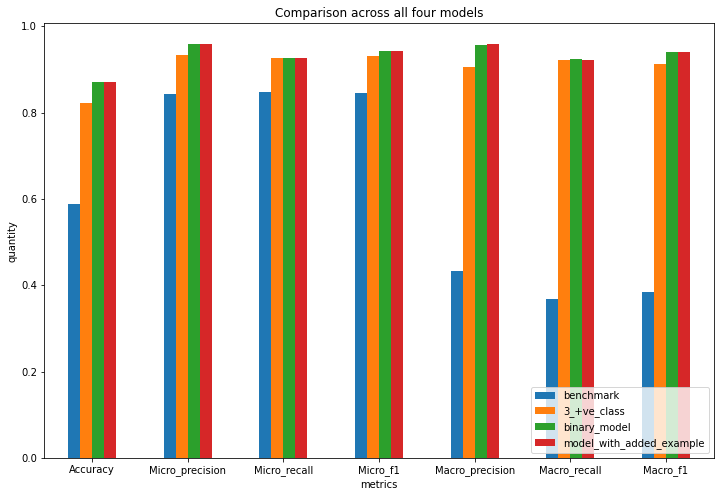

In [73]:
#plotting improvement in the model across all models
plots(['benchmark', '3_+ve_class', 'binary_model', 'model_with_added_example'], 'Comparison across all four models')

Finally, I tried adding some examples I isolated at the start of the analysis to see if they’d improve the model when readded at the end. The above shows there is no noticeable difference. It looks like we’d need a sizeable additional training data to improve the model.

TO BE CONTINUED

- need to write function to join new trainind data and automatically classify out of sample dataset. function will be using 
some of the snippets i have above.
- include a confusion matrix in the evaluation process
- see the effect of reducing C to value of 0.2 or 0.3 or tuning for any other hyperparameters of the model
- see if i can run the code on COLAB, Google AI Platform, Google NLP API, and Google AutoML
- also check if i develop same model considering time and space complexity